In [1]:
import torch

from models.predictionnet import ResBlock, UpSample, DownSample, AttentionBlock, DownBlock, UpBlock, MidBlock, PadBlock, UnPadBlock, UNet

from matplotlib import pyplot as plt

In [3]:
block = ResBlock(64, 64)

x = torch.randn(1, 64, 32, 32)
y = block(x)
print(x.shape, y.shape)
print(block)

torch.Size([1, 64, 32, 32]) torch.Size([1, 64, 32, 32])
ResBlock(
  (layers): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (2): SiLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  )
  (skip_connection): Identity()
  (activation): SiLU()
)


In [7]:
up = UpSample()

x = torch.randn(1, 64, 45, 22)
y = up(x)
print(x.shape, y.shape)
print(up)

torch.Size([1, 64, 45, 22]) torch.Size([1, 64, 90, 44])
UpSample()


In [4]:
down = DownSample()

x = torch.randn(1, 64, 32, 32)
y = down(x)
print(x.shape, y.shape)
print(down)

torch.Size([1, 64, 32, 32]) torch.Size([1, 64, 16, 16])
DownSample(
  (op): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


In [5]:
att = AttentionBlock(32, 8)

x = torch.randn(1, 32, 16, 16)
y = att(x)

print(x.shape, y.shape)
print(att)

torch.Size([1, 32, 16, 16]) torch.Size([1, 32, 16, 16])
AttentionBlock(
  (norm): GroupNorm(32, 32, eps=1e-05, affine=True)
  (qkv): Conv1d(32, 96, kernel_size=(1,), stride=(1,))
  (attention): QKVAttention()
  (proj_out): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
)


In [6]:
downblock = DownBlock(64, 128, 1, True)

x = torch.randn(1, 64, 90, 45)
y = downblock(x)

print(x.shape, y.shape)
print(downblock)

# print number of parameters in the model
print("Number of parameters in DownBlock:", sum(p.numel() for p in downblock.parameters()))

torch.Size([1, 64, 90, 45]) torch.Size([1, 128, 45, 22])
DownBlock(
  (resblocks): ModuleList(
    (0): ResBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(32, 128, eps=1e-05, affine=True)
        (2): SiLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(32, 128, eps=1e-05, affine=True)
      )
      (skip_connection): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (activation): SiLU()
    )
  )
  (attentionblocks): ModuleList(
    (0): AttentionBlock(
      (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
      (qkv): Conv1d(128, 384, kernel_size=(1,), stride=(1,))
      (attention): QKVAttention()
      (proj_out): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
  )
  (down): DownSample(
    (op): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
)
Number of parameters in DownBlock: 296576


torch.Size([1, 128, 32, 32]) torch.Size([1, 256, 32, 32])


In [7]:
x = torch.randn(1, 64, 32, 32)

downblock = DownBlock(64, 128, 2, True)
upblock = UpBlock(128, 64, 2, True)
mid = torch.nn.Sequential(
    MidBlock(128, 256, True),
    MidBlock(256, 256, True),
    MidBlock(256, 128, True),
)

h, skip = downblock.forward(x)

h = mid(h)

h = upblock.forward(h, skip)

print(x.shape, h.shape)
print(downblock, upblock, mid)

# print number of parameters in the model
print("Number of parameters in DownBlock:", sum(p.numel() for p in downblock.parameters()))
print("Number of parameters in UpBlock:", sum(p.numel() for p in upblock.parameters()))
print("Number of parameters in MidBlock:", sum(p.numel() for p in mid.parameters()))

torch.Size([1, 64, 32, 32]) torch.Size([1, 64, 32, 32])
DownBlock(
  (resblocks): ModuleList(
    (0): ResBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(32, 128, eps=1e-05, affine=True)
        (2): SiLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(32, 128, eps=1e-05, affine=True)
      )
      (skip_connection): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (activation): SiLU()
    )
    (1): ResBlock(
      (layers): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(32, 128, eps=1e-05, affine=True)
        (2): SiLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(32, 128, eps=1e-05, affine=True)
      )
      (skip_connection): Identity()
      (activation): SiLU()
    )
  )
  (attentionblocks): Module

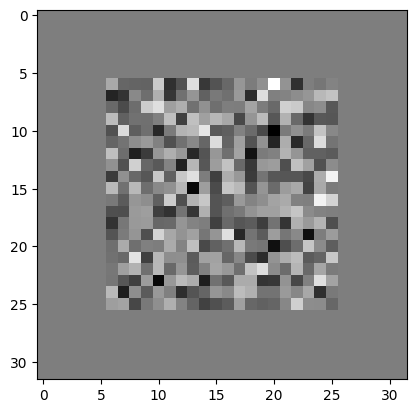

torch.Size([1, 1, 20, 20]) torch.Size([1, 1, 32, 32])


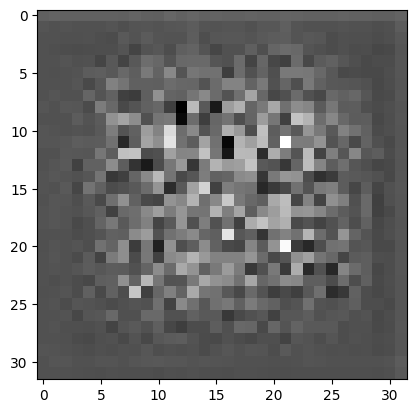

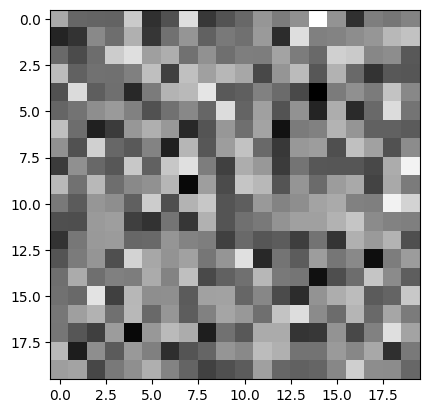

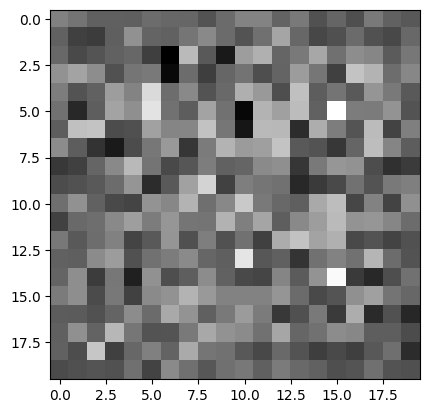

Number of parameters in MidBlock: 5119617


In [ ]:
x = torch.randn(1, 1, 20, 20)

pad = PadBlock((6, 6, 6, 6))
unpad = UnPadBlock((6, 6, 6, 6))

y = pad(x)

plt.imshow(y[0, 0].detach().numpy(), cmap="gray")
plt.show()

mid = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    MidBlock(64, 256, True),
    MidBlock(256, 256, True),
    MidBlock(256, 64, True),
    torch.nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
)

y = mid(y)

x_hat = unpad(y)
print(x.shape, y.shape)

plt.imshow(y[0, 0].detach().numpy(), cmap="gray")
plt.show()

plt.imshow(x[0, 0].detach().numpy(), cmap="gray")
plt.show()

plt.imshow(x_hat[0, 0].detach().numpy(), cmap="gray")
plt.show()


# print number of parameters in the model
print("Number of parameters in MidBlock:", sum(p.numel() for p in mid.parameters()))

torch.Size([1, 64, 180, 90]) torch.Size([1, 64, 180, 90])
Loss: 1.2985087633132935


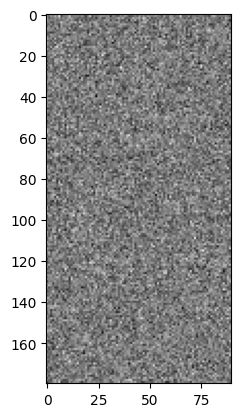

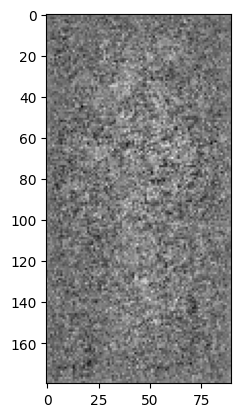

Number of parameters in conv_in: 36928
Number of parameters in conv_out: 36928
Number of parameters in DownBlock 1: 525952
Number of parameters in DownBlock 2: 2100480
Number of parameters in DownBlock 3: 10498560
Number of parameters in DownBlock 4: 11546624
Number of parameters in MidBlock 1: 10494976
Number of parameters in MidBlock 2: 10494976
Number of parameters in MidBlock 3: 10494976
Number of parameters in UpBlock 1: 14430720
Number of parameters in UpBlock 2: 4921600
Number of parameters in UpBlock 3: 1099392
Number of parameters in UpBlock 4: 275264
Number of parameters in PadBlock: 0
Number of parameters in UnPadBlock: 0


In [34]:
# unet test

input = torch.randn(1, 64, 180, 90)

pad = PadBlock((3, 3, 6, 6))
unpad = UnPadBlock((3, 3, 6, 6))

conv_in = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
conv_out = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

downblock_1 = DownBlock(64, 128, 2, False)
downblock_2 = DownBlock(128, 256, 2, False)
downblock_3 = DownBlock(256, 512, 2, True)
downblock_4 = DownBlock(512, 512, 2, True)

midblock_1 = MidBlock(512, 512, True)
midblock_2 = MidBlock(512, 512, True)
midblock_3 = MidBlock(512, 512, True)

upblock_1 = UpBlock(512, 512, 2, True)
upblock_2 = UpBlock(512, 256, 2, True)
upblock_3 = UpBlock(256, 128, 2, False)
upblock_4 = UpBlock(128, 64, 2, False)

x = pad(input)

x = conv_in(x)

h, skip_1 = downblock_1.forward(x)
h, skip_2 = downblock_2.forward(h)
h, skip_3 = downblock_3.forward(h)
h, skip_4 = downblock_4.forward(h)

h = midblock_1(h)
h = midblock_2(h)
h = midblock_3(h)

h = upblock_1.forward(h, skip_4)
h = upblock_2.forward(h, skip_3)
h = upblock_3.forward(h, skip_2)
h = upblock_4.forward(h, skip_1)

h = conv_out(h)
h = unpad(h)

print(input.shape, h.shape)

loss = torch.nn.functional.mse_loss(h, input)
print("Loss:", loss.item())

loss.backward()


plt.imshow(input[0, 0].detach().numpy(), cmap="gray")
plt.show()

plt.imshow(h[0, 0].detach().numpy(), cmap="gray")
plt.show()

# print number of parameters in the model
print("Number of parameters in conv_in:", sum(p.numel() for p in conv_in.parameters()))
print("Number of parameters in conv_out:", sum(p.numel() for p in conv_out.parameters()))
print("Number of parameters in DownBlock 1:", sum(p.numel() for p in downblock_1.parameters()))
print("Number of parameters in DownBlock 2:", sum(p.numel() for p in downblock_2.parameters()))
print("Number of parameters in DownBlock 3:", sum(p.numel() for p in downblock_3.parameters()))
print("Number of parameters in DownBlock 4:", sum(p.numel() for p in downblock_4.parameters()))
print("Number of parameters in MidBlock 1:", sum(p.numel() for p in midblock_1.parameters()))
print("Number of parameters in MidBlock 2:", sum(p.numel() for p in midblock_2.parameters()))
print("Number of parameters in MidBlock 3:", sum(p.numel() for p in midblock_3.parameters()))
print("Number of parameters in UpBlock 1:", sum(p.numel() for p in upblock_1.parameters()))
print("Number of parameters in UpBlock 2:", sum(p.numel() for p in upblock_2.parameters()))
print("Number of parameters in UpBlock 3:", sum(p.numel() for p in upblock_3.parameters()))
print("Number of parameters in UpBlock 4:", sum(p.numel() for p in upblock_4.parameters()))
print("Number of parameters in PadBlock:", sum(p.numel() for p in pad.parameters()))
print("Number of parameters in UnPadBlock:", sum(p.numel() for p in unpad.parameters()))

In [2]:
input = torch.randn(8, 64, 180, 90).to("cuda")

unet = UNet(
    in_channels=64,
    base_channels=128,
    channels_mult=[1, 1, 2, 2, 4],
    num_resblocks=2,
    attention_layers=[False, False, True, True, True],
    pads=(3, 3, 6, 6)
).to("cuda")

x = unet(input)
print(input.shape, x.shape)

for i in range(100):
    x = unet(x)

plt.imshow(input[0, 0].detach().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(x[0, 0].detach().cpu().numpy(), cmap="gray")
plt.show()

torch.cuda.empty_cache()

torch.Size([8, 64, 180, 90]) torch.Size([8, 64, 180, 90])


KeyboardInterrupt: 